## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. токенизация
2. приведение к нижнему регистру
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать параметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.

In [2]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split 

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
clothes = pd.read_csv('/content/drive/MyDrive/Data/women-clothing-accessories.csv', sep='\t', usecols=[0, 1])

clothes

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,positive
89996,Накидка шикарная. Спасибо большое провдо линяе...,positive
89997,спасибо большое ) продовца рекомендую.. заказа...,positive
89998,Очень довольна заказом! Меньше месяца в РБ. К...,positive


In [5]:
X_train, X_test, y_train, y_test = train_test_split(clothes.review, clothes.sentiment, train_size = 0.7)

**Выполним предобработку текста:**

Выполним токенезацию:

In [6]:
import nltk
from nltk.tokenize import word_tokenize

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
X_train = X_train.apply(word_tokenize)
X_test = X_test.apply(word_tokenize)

X_train

50490                         [маломерит, ,, синтетика, .]
27723    [Платье, пришло, огромное, ,, примерно, размер...
40073    [жесть, просто, ,, на, 44-46, взяла, xxl, рука...
6866     [Не, соответствует, размеру, !, Рукав, короче,...
18023    [Не, кашимир, ,, синтетик, не, понятный, ,, пр...
                               ...                        
64481    [Платье, просто, шикарное, !, При, кажущейся, ...
35558    [Платье, хорошее, ,, но, складки, на, нем, как...
69794                                             [хорошо]
49244    [Швы, не, аккуратные, !, Нитки, темнее, шапки,...
47155    [Заказывала, в, Москве, 29, мая, ,, получила, ...
Name: review, Length: 62999, dtype: object

Приведем к нижнему регистру:

In [9]:
for item in X_train:
  for i in range(len(item)):
    item[i] = item[i].lower()

for item in X_test:
  for i in range(len(item)):
    item[i] = item[i].lower()

X_train

50490                         [маломерит, ,, синтетика, .]
27723    [платье, пришло, огромное, ,, примерно, размер...
40073    [жесть, просто, ,, на, 44-46, взяла, xxl, рука...
6866     [не, соответствует, размеру, !, рукав, короче,...
18023    [не, кашимир, ,, синтетик, не, понятный, ,, пр...
                               ...                        
64481    [платье, просто, шикарное, !, при, кажущейся, ...
35558    [платье, хорошее, ,, но, складки, на, нем, как...
69794                                             [хорошо]
49244    [швы, не, аккуратные, !, нитки, темнее, шапки,...
47155    [заказывала, в, москве, 29, мая, ,, получила, ...
Name: review, Length: 62999, dtype: object

Лемматезация:

In [10]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 8.2 MB 10.5 MB/s 


In [11]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [12]:
for item in X_train:
  for i in range(len(item)):
    item[i] = pymorphy2_analyzer.parse(item[i])[0].normal_form

for item in X_test:
  for i in range(len(item)):
    item[i] = pymorphy2_analyzer.parse(item[i])[0].normal_form

Удалим стоп-слова:

In [13]:
X_train_copy = X_train
X_test_copy = X_test

In [14]:
from nltk.corpus import stopwords

In [15]:
X_train[1:]

27723    [платье, прийти, огромный, ,, примерно, размер...
40073    [жесть, просто, ,, на, 44-46, взять, xxl, рука...
6866     [не, соответствовать, размер, !, рукав, короче...
18023    [не, кашимиро, ,, синтетик, не, понятный, ,, п...
50001    [прийти, пижама, ,, в, принцип, за, этот, день...
                               ...                        
64481    [платье, просто, шикарный, !, при, кажущийся, ...
35558    [платье, хороший, ,, но, складка, на, немой, к...
69794                                             [хорошо]
49244    [шов, не, аккуратный, !, нитка, тёмный, шапка,...
47155    [заказывать, в, москва, 29, май, ,, получить, ...
Name: review, Length: 62998, dtype: object

In [16]:
noise = stopwords.words('russian')

for item in X_train:
  for word in item: 
    if word in noise: 
      item.remove(word)

for item in X_test:
  for word in item: 
    if word in noise: 
      item.remove(word)

X_train[1:]

27723    [платье, прийти, огромный, ,, примерно, размер...
40073    [жесть, просто, ,, 44-46, взять, xxl, рукав, н...
6866     [соответствовать, размер, !, рукав, короче, ,,...
18023    [кашимиро, ,, синтетик, понятный, ,, противный...
50001    [прийти, пижама, ,, принцип, этот, деньга, оно...
                               ...                        
64481    [платье, просто, шикарный, !, кажущийся, прост...
35558    [платье, хороший, ,, складка, немой, как-будто...
69794                                                   []
49244    [шов, аккуратный, !, нитка, тёмный, шапка, ,, ...
47155    [заказывать, москва, 29, май, ,, получить, 22,...
Name: review, Length: 62998, dtype: object

Удалим пунктуацию:

In [17]:
for item in X_train:
  for word in item: 
    if not(word.isalpha()): 
      item.remove(word)

for item in X_test:
  for word in item: 
    if not(word.isalpha()) : 
      item.remove(word)

X_train[1:]

27723    [платье, прийти, огромный, примерно, размер, l...
40073    [жесть, просто, 44-46, взять, xxl, рукав, норм...
6866     [соответствовать, размер, рукав, короче, напис...
18023    [кашимиро, синтетик, понятный, противный, тело...
50001    [прийти, пижама, принцип, этот, деньга, оно, с...
                               ...                        
64481    [платье, просто, шикарный, кажущийся, простота...
35558    [платье, хороший, складка, немой, намазать, тё...
69794                                                   []
49244    [шов, аккуратный, нитка, тёмный, шапка, торчат...
47155    [заказывать, москва, май, получить, июль, 48р-...
Name: review, Length: 62998, dtype: object

In [18]:
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

X_train[1:]

27723    платье прийти огромный примерно размер l a мой...
40073    жесть просто 44-46 взять xxl рукав норма грудь...
6866     соответствовать размер рукав короче написать о...
18023     кашимиро синтетик понятный противный тело тёплый
50001    прийти пижама принцип этот деньга оно следоват...
                               ...                        
64481    платье просто шикарный кажущийся простота выгл...
35558    платье хороший складка немой намазать тёмный т...
69794                                                     
49244    шов аккуратный нитка тёмный шапка торчать лице...
47155    заказывать москва май получить июль 48р-р xl о...
Name: review, Length: 62998, dtype: object

**Выполним векторизацию:**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import * 
import matplotlib.pyplot as plt

**Bag of words:**

In [75]:
accuracy = []

for i in range(1, 5):
  vectorizer = CountVectorizer(ngram_range=(1, i))
  vectorized_x_train = vectorizer.fit_transform(X_train)
  
 
  clf = MultinomialNB()
  clf.fit(vectorized_x_train, y_train)

  vectorized_x_test = vectorizer.transform(X_test)
  pred = clf.predict(vectorized_x_test)
  accuracy.append(accuracy_score(y_test, pred))
  print(vectorized_x_train.shape)
 
print('\n', vectorized_x_train.max(-1))

(62999, 22884)
(62999, 334882)
(62999, 940757)
(62999, 1604939)

   (0, 0)	1
  (1, 0)	1
  (2, 0)	1
  (3, 0)	2
  (4, 0)	1
  (5, 0)	2
  (6, 0)	1
  (7, 0)	1
  (8, 0)	2
  (9, 0)	1
  (10, 0)	4
  (11, 0)	2
  (12, 0)	1
  (13, 0)	2
  (14, 0)	1
  (15, 0)	1
  (16, 0)	2
  (17, 0)	1
  (18, 0)	1
  (19, 0)	1
  (20, 0)	1
  (21, 0)	2
  (22, 0)	2
  (23, 0)	1
  (24, 0)	1
  :	:
  (62973, 0)	2
  (62974, 0)	1
  (62975, 0)	2
  (62976, 0)	1
  (62977, 0)	1
  (62978, 0)	1
  (62979, 0)	1
  (62980, 0)	1
  (62981, 0)	2
  (62982, 0)	2
  (62983, 0)	1
  (62984, 0)	2
  (62985, 0)	2
  (62986, 0)	1
  (62987, 0)	1
  (62988, 0)	1
  (62989, 0)	1
  (62990, 0)	1
  (62991, 0)	1
  (62992, 0)	1
  (62993, 0)	1
  (62994, 0)	4
  (62995, 0)	1
  (62997, 0)	1
  (62998, 0)	2


Text(0, 0.5, 'Accuracy')

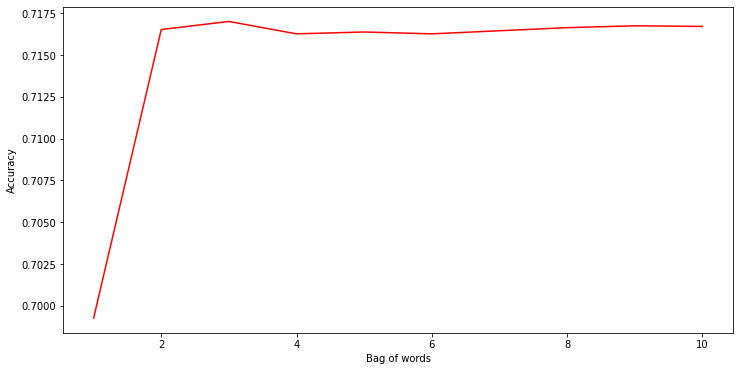

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), accuracy, color='red')
plt.xlabel('Bag of words')
plt.ylabel('Accuracy')

Для мешка слов примем диапазон n = (1, 2)

**Tf-Idf векторайзер:**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [23]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__min_df": (0.01, 0.05, 0.1, 0.2),
    'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2), (1, 3)),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: ignored

In [ ]:
grid_search.best_estimator_

Для TF-IDF имеем следующие параметры: **n = (1, 3), max_df=0.5, min_df=0.01**

**Векторайзер: символьные n-граммы:**

In [ ]:
accuracy = []

for i in range(3, 16):
  vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, i))
  vectorized_x_train = vectorizer.fit_transform(X_train)

  clf = MultinomialNB()
  clf.fit(vectorized_x_train, y_train)

  vectorized_x_test = vectorizer.transform(X_test)
  pred = clf.predict(vectorized_x_test)
  accuracy.append(accuracy_score(y_test, pred))

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(3, 16), accuracy, color='red')
plt.xlabel('Char')
plt.ylabel('Accuracy')

Для символьных n-грамм примем диапазон: n = (3, 14)

**Приведем оценку качества моделей:**

In [ ]:
vectorizer1 = CountVectorizer(ngram_range=(1, 2))
vectorized_x_train1 = vectorizer1.fit_transform(X_train)

clf1 = MultinomialNB()
clf1.fit(vectorized_x_train1, y_train)

vectorized_x_test1 = vectorizer1.transform(X_test)
pred1 = clf1.predict(vectorized_x_test1)

vectorizer2 = TfidfVectorizer(max_df=0.5, max_features=None, min_df=0.01, ngram_range=(1, 3))
vectorized_x_train2 = vectorizer2.fit_transform(X_train)

clf2 = MultinomialNB()
clf2.fit(vectorized_x_train2, y_train)

vectorized_x_test2 = vectorizer2.transform(X_test)
pred2 = clf2.predict(vectorized_x_test2)

vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(3, 14))
vectorized_x_train3 = vectorizer3.fit_transform(X_train)

clf3 = MultinomialNB()
clf3.fit(vectorized_x_train3, y_train)

vectorized_x_test3 = vectorizer3.transform(X_test)
pred3 = clf3.predict(vectorized_x_test3)

In [ ]:
data = {'Precision':[precision_score(y_test, pred1, average='weighted'), precision_score(y_test, pred2, average='weighted'), precision_score(y_test, pred3, average='weighted')],
        'Recall':[recall_score(y_test, pred1, average='weighted'), recall_score(y_test, pred2, average='weighted'), recall_score(y_test, pred3, average='weighted')],
        'F1-Score':[f1_score(y_test, pred1, average='weighted'), f1_score(y_test, pred2, average='weighted'), f1_score(y_test, pred3, average='weighted')],
        'Accuracy':[accuracy_score(y_test, pred1), accuracy_score(y_test, pred2), accuracy_score(y_test, pred3)]}

df = pd.DataFrame(data, index =['Мешок n-грамм',
                                'TFIDF',
                                'Символьные n-граммы'])
df

**Таким образом, мешок n-грамм показал лучшие результаты**

## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

In [ ]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [ ]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

Вопрос на внимательность: почему нет abcx?

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [ ]:
s = "How is it going there?"

result = re.findall(r'\b\w{2}', s)
print(result)

### split
разделяет строку по заданному шаблону


In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

можно указать максимальное количество разбиений

In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [ ]:
s = "Test 1. Test 2. Test 3. Test 4."

result = re.split(r'\.', s, maxsplit=2)
print(result)

### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [ ]:
result = re.sub('a', 'b', 'abcabc')
print (result)

**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [ ]:
s = "Test 1234 test 5678"

result =  re.sub(r'\d+', 'DIG', s)
print(result)

**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

In [ ]:
s = "This is the place where i'm forking from: https://github.com"

result = re. sub(r'http\S+', '', s)
print(result)

### compile
компилирует регулярное выражение в отдельный объект

In [ ]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [ ]:
s = "Charlie, you shouldn't have left me."

result = re.compile(r'\w{4,}')
result.findall(s)

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [ ]:
emails = "abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz"

result = re.compile(r'@\w+.\w+')
result.findall(emails)